(0.9999999999999992+0j) (1.08+0j)
(0.9999999999999992+0j) (1.04+0j)
(0.9999999999999992+0j) (0.9199999999999999+0j)
(0.9999999999999992+0j) (0.7999999999999998+0j)
(0.9999999999999992+0j) (0.8+0j)
(0.9999999999999992+0j) (1.08+0j)
(0.9999999999999992+0j) (0.8400000000000001+0j)
(0.9999999999999992+0j) (1.12+0j)
(0.9999999999999992+0j) (1+0j)
(0.9999999999999992+0j) (1.08+0j)


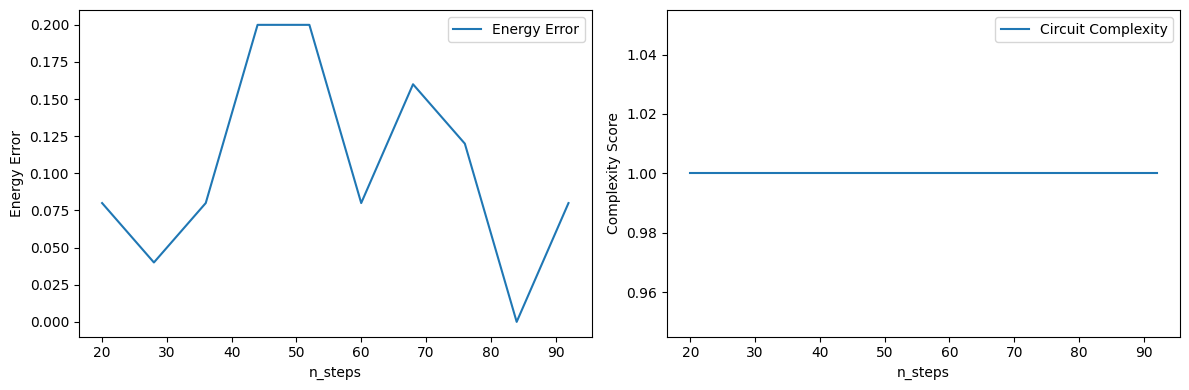

Best n_steps: 84
Circuit statistics for best solution:
  Depth: 1
  2-qubit gates: 1
  Gate counts: {'CircBox': 1}
84


In [1]:
import numpy as np
from pytket.circuit import Circuit
from pytket.utils import QubitPauliOperator
from scipy.linalg import expm

from hamiltonian_sim import (
    get_hamiltonian_simulation_circbox,
    get_xxz_chain_hamiltonian,
)

from pytket.utils.expectations import get_operator_expectation_value
from pytket.extensions.qiskit import AerBackend

import matplotlib.pyplot as plt

# from pytket.pauli import QubitPauliOperator
# from pytket.utils import expectation_from_pauli
from typing import Tuple
from collections import Counter

# def gen_trotter_step(hamiltonian: QubitPauliOperator, qubits: list[Qubit], n_steps: int) -> Circuit:
    # return get_hamiltonian_simulation_circbox(hamiltonian, len(qubits), n_steps, 1)


def analyze_circuit_parameters(circ: Circuit) -> dict:
    """Analyze a quantum circuit for its parameters."""
    info = {}

    info["n_qubits"] = circ.n_qubits
    info["n_bits"] = circ.n_bits
    info["depth"] = circ.depth()
    info["n_2qb_gates"] = circ.n_2qb_gates()

    gate_counter = Counter()
    for cmd in circ.get_commands():
        gate_name = str(cmd.op)
        gate_counter[gate_name] += 1
    info["gate_counts"] = dict(gate_counter)

    param_gates = []
    for cmd in circ.get_commands():
        op_name = str(cmd.op).split()[0]
        if op_name in ["Rx", "Ry", "Rz"]:
            angle = float(str(cmd.op).split("(")[1].split(")")[0])
            param_gates.append((op_name, angle, [q.index[0] for q in cmd.qubits]))

    info["rotation_gates"] = param_gates

    return info

class TrotterStep:
    """Class for simulating quantum systems using Trotter decomposition.

    This class implements Trotter-Suzuki decomposition for quantum simulation,
    allowing analysis of energy evolution and optimization of Trotter steps.

    Attributes:
        hamiltonian: The system Hamiltonian as a QubitPauliOperator
        hamiltonian_mat: Dense matrix representation of the Hamiltonian
        qubits: Number of qubits in the system
        end_time: Total simulation time
        time_steps: Number of time points to evaluate
        backend: Quantum backend for simulation (AerBackend)
    """

    def __init__(self, hamiltonian: QubitPauliOperator, qubits: int, end_time: float, time_steps: int):
        """Initialize the TrotterStep simulator.

        Args:
            hamiltonian: System Hamiltonian as QubitPauliOperator
            qubits: Number of qubits in the system
            end_time: Total simulation time
            time_steps: Number of time points to evaluate
        """
        self.hamiltonian = hamiltonian
        self.hamiltonian_mat = hamiltonian.to_sparse_matrix().todense()
        self.qubits = qubits
        self.end_time = end_time
        self.time_steps = time_steps
        # self.backend = AerStateBackend()
        self.backend = AerBackend()
        # self.n_steps = n_steps

    def simulate_steps(self, n_steps: int):
        """Simulate system evolution over time using Trotter decomposition.

        Args:
            n_steps: Number of Trotter steps to use

        Returns:
            tuple: (times, energies) where times is array of time points and
                  energies is array of corresponding energy expectation values
        """
        times = np.linspace(0, self.end_time, self.time_steps)
        energies = []
        for t in times:
            circ = Circuit(self.qubits)
            circbox = get_hamiltonian_simulation_circbox(self.hamiltonian, self.qubits, t, n_steps)
            circ.add_circbox(circbox, list(range(self.qubits)))
            energies.append(get_operator_expectation_value(circ, self.hamiltonian, self.backend, 50))

        return times, energies

    def get_energy(self, n_steps: int):
        """Get energy expectation value for given number of Trotter steps.

        Args:
            n_steps: Number of Trotter steps to use

        Returns:
            float: Energy expectation value
        """
        # t_step = self.end_time / n_steps
        circ = Circuit(self.qubits)
        circbox = get_hamiltonian_simulation_circbox(self.hamiltonian, self.qubits, self.end_time, n_steps)
        circ.add_circbox(circbox, list(range(self.qubits)))
        # return self.backend.run_circuit(circ).get_state()
        return get_operator_expectation_value(circ, self.hamiltonian, self.backend, 50)

    def get_error(self, n_steps: int):
        """Calculate error between Trotter approximation and exact evolution.

        Compares energy expectation value from Trotter simulation to exact
        solution from matrix exponential.

        Args:
            n_steps: Number of Trotter steps to use

        Returns:
            tuple: (error, exact_energy, approximate_energy) where error is absolute
                  difference between exact and approximate energies
        """
        # statevector = self.get_statevector(n_steps)

        U_exact = expm(-1j * self.hamiltonian_mat * self.end_time)
        psi0 = np.zeros(2**self.qubits)
        psi0[0] = 1
        psi_exact = U_exact @ psi0
        ex_res = (np.conj(psi_exact) @ self.hamiltonian_mat @ psi_exact).item()

        cur_res = self.get_energy(n_steps)
        print(ex_res, cur_res)
        return abs(np.abs(ex_res) - np.abs(cur_res)), ex_res, cur_res

    def get_circuit_stats(self, n_steps: int) -> dict:
        """Get circuit statistics for a given number of Trotter steps."""
        circ = Circuit(self.qubits)
        circbox = get_hamiltonian_simulation_circbox(self.hamiltonian, self.qubits, self.end_time, n_steps)
        circ.add_circbox(circbox, list(range(self.qubits)))
        return analyze_circuit_parameters(circ)

    def find_best_n_steps(self, complexity_weight: float = 0.3, steps_range: Tuple[int, int, int] = (20, 100, 8)):
        """Find optimal number of Trotter steps considering both accuracy and circuit complexity.
           Goes along the accuracy-complexity tradeoff frontier and finds the best n_steps.

        Args:
            complexity_weight: Weight between 0 and 1 for how much to consider circuit complexity vs accuracy.
                             0 means only consider accuracy, 1 means only consider circuit complexity.
        """
        steps = list(range(*steps_range))
        ex_energies = []
        cur_energies = []
        dif_energies = []
        circuit_complexities = []

        for n_steps in steps:
            # Get energy error
            a, e, c = self.get_error(n_steps)
            ex_energies.append(e)
            cur_energies.append(c)
            dif_energies.append(a)

            # Get circuit complexity score
            stats = self.get_circuit_stats(n_steps)
            complexity_score = stats["depth"] * 0.4 + stats["n_2qb_gates"] * 0.6
            circuit_complexities.append(complexity_score)

        # Normalize both metrics to [0,1] range
        norm_errors = np.array(dif_energies) / max(dif_energies)
        norm_complexity = np.array(circuit_complexities) / max(circuit_complexities)

        # Combined score with weighting
        combined_scores = (1 - complexity_weight) * norm_errors + complexity_weight * norm_complexity

        # Plot results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        ax1.plot(steps, dif_energies, label='Energy Error')
        ax1.set_xlabel('n_steps')
        ax1.set_ylabel('Energy Error')
        ax1.legend()

        ax2.plot(steps, circuit_complexities, label='Circuit Complexity')
        ax2.set_xlabel('n_steps')
        ax2.set_ylabel('Complexity Score')
        ax2.legend()

        plt.tight_layout()
        plt.show()

        best_n_steps = steps[np.argmin(combined_scores)]
        best_stats = self.get_circuit_stats(best_n_steps)

        print(f"Best n_steps: {best_n_steps}")
        print("Circuit statistics for best solution:")
        print(f"  Depth: {best_stats['depth']}")
        print(f"  2-qubit gates: {best_stats['n_2qb_gates']}")
        print(f"  Gate counts: {best_stats['gate_counts']}")

        return best_n_steps

    def get_trotter_step_with_best_n_steps(self):
        n_steps = self.find_best_n_steps()
        times, energies = self.simulate_steps(n_steps)
        plt.plot(times, energies)
        plt.xlabel('time')
        plt.ylabel('energy')
        plt.show()

hamiltonian = get_xxz_chain_hamiltonian(2, 1.0)
trotter_step = TrotterStep(hamiltonian, 2, 10.0, 30)
print(trotter_step.find_best_n_steps())
